In [3]:
from sklearn import metrics, ensemble
from sklearn.model_selection import cross_validate,GridSearchCV,train_test_split
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [4]:
train = pd.read_csv('input/train.csv')
train = train.sample(frac=0.5)

In [5]:
songs = pd.read_csv('input/songs.csv')
train = pd.merge(train, songs, on='song_id', how='left')
del songs

members = pd.read_csv('input/members.csv')
train = pd.merge(train, members, on='msno', how='left')
del members

song_extra_info = pd.read_csv('input/song_extra_info.csv')
train = pd.merge(train, song_extra_info, on='song_id', how='left')
del song_extra_info

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750000 entries, 0 to 749999
Data columns (total 20 columns):
msno                      750000 non-null object
song_id                   750000 non-null object
source_system_tab         747638 non-null object
source_screen_name        715503 non-null object
source_type               747944 non-null object
target                    750000 non-null int64
song_length               749988 non-null float64
genre_ids                 738949 non-null object
artist_name               749988 non-null object
composer                  587570 non-null object
lyricist                  437793 non-null object
language                  749984 non-null float64
city                      750000 non-null int64
bd                        750000 non-null int64
gender                    452950 non-null object
registered_via            750000 non-null int64
registration_init_time    750000 non-null int64
expiration_date           750000 non-null int64
name       

In [7]:
train.describe()

,target,song_length,language,city,bd,registered_via,registration_init_time,expiration_date
count,750000.000000,7.499880e+05,749984.000000,750000.000000,750000.000000,750000.000000,7.500000e+05,7.500000e+05
mean,0.665844,2.454337e+05,18.477625,7.567128,17.460075,6.775365,2.012778e+07,2.017149e+07
std,0.471695,5.928003e+04,21.163488,6.585206,21.108548,2.296369,2.978766e+04,3.869867e+03
min,0.000000,2.716000e+03,-1.000000,1.000000,-43.000000,3.000000,2.004033e+07,2.004102e+07
25%,0.000000,2.152020e+05,3.000000,1.000000,0.000000,4.000000,2.011071e+07,2.017091e+07
50%,1.000000,2.423110e+05,3.000000,5.000000,21.000000,7.000000,2.013102e+07,2.017093e+07
75%,1.000000,2.727180e+05,52.000000,13.000000,28.000000,9.000000,2.015101e+07,2.017101e+07
max,1.000000,7.371499e+06,59.000000,22.000000,1030.000000,13.000000,2.016121e+07,2.020102e+07


In [8]:
train.head(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date,name,isrc
0,ZlTSQ1AkVZHsqjmxT9LY720XxNAqkDyHspt2lpjZMm0=,fWtBf0GSJnwaWiNisVGnnZjFAT8vmZ8n1SB7FAIlmOQ=,my library,Local playlist more,local-playlist,1,225280.0,465,郭靜 (Claire Kuo),Victor劉偉德/吳夢奇,艾怡良/艷薇,3.0,1,0,NaN,7,20131011,20170911,可惜 (Sorry to Say Goodbye),TWA211551801
1,BAN2f6KT+KXSbD3Tnau6aKDDAIF/tiBo4kMRFdArFXc=,fEAIgFRWmhXmo6m3ukQeqRksZCcO/7CjkqNckRHiVQo=,discover,Unknown,online-playlist,1,179258.0,458,葛仲珊 (MISS KO),Miss Ko| Razor 'n Guido,NaN,3.0,15,20,male,9,20100208,20170906,皇后區的皇后,TWUM71600104
2,UjuPJCQo/YoGVR/yJ+CocmWUk2czJE0BBKqaPpVYV64=,WDhQhhbq+bwhBY642Fx3e5eGBdvqzzXmwiouCaVI0R0=,my library,Local playlist more,local-library,0,252000.0,458,許仁杰 (Stanly Hsu),許仁杰/張簡君偉,張簡君偉,3.0,13,23,female,9,20130518,20171202,單身剛好,TWCG31600001
3,qv24DyXUmZVHzxwcgPJRy7qFeni3fdd2q47kxiCekjs=,4m+cvkd9Y5L16enjf9nRufbfV+HxYguQ7FgvazLQ3I8=,my library,Local playlist more,local-library,0,206576.0,465,羅志祥 (Show Lo),NaN,NaN,3.0,1,0,NaN,9,20151125,20170914,鬧翻天,TWEM31211002
4,lGDHl8s6FJTqb5a957xraHq7Z6tO00sDVMidb584ZjM=,+W5WCJFc7k7UJLArWZKMYmkrO3RoOm6VrmD7yJfVKRI=,my library,Local playlist more,local-library,0,162168.0,465,Fergie,J. Donald| Jamal Jones| Stacy Ferguson| J. Sol...,NaN,52.0,4,22,female,7,20110624,20171005,M.I.L.F. $,USUM71604730
5,lR7ML18COc/LyqGfeQiCojiuTgQ4a11/XIznJ58e9kQ=,o+fLXtu2auUsQNTfB141c7dPE5HnkvVF9wjBK5dHSjk=,my library,Local playlist more,local-playlist,1,239258.0,1259,Machine Gun Kelly| Camila Cabello,"Camila Cabello| Colson Baker pka ""MGK"" for EST...",NaN,52.0,1,0,NaN,4,20151024,20171004,Bad Things,USUM71609854
6,6ZfzjO7RYXWvEQEQmXrC+Tqpy1QqgErMbbK6S5gN86M=,5nsq4I7YcXGj0DKwMsuanz70I09xrCn8OmIJ6127pqg=,my library,Local playlist more,local-library,1,195999.0,458,王若琳 (Joanna Wang),Peter Sven Kvint| Vincent Paul Degiorgio,Peter Sven Kvint| Vincent Paul Degiorgio,3.0,1,0,NaN,7,20150714,20170930,有你的快樂 (You Ni De Quai Le),TWA470722014
7,KP9C2DhtapjZuDpH3VNvtKQlI3LraMhMnkHw470H7XE=,FzqO7OTM1QVVssM6J7PHtA2l8MFKD7qejKSPcdqw03o=,my library,NaN,local-library,1,218801.0,465,炎亞綸 (Aaron Yan),JerryC,周耀輝,3.0,13,43,female,9,20151001,20170911,一刀不剪,TWD951446201
8,SyjAwOJwRtBznliPX/ujk5jXIzMkiNxZ3taAHDWa3pY=,kgOSHwInwdvDK0rUu8OXvPDITvzPKfeNl2pA96PJBfs=,radio,Radio,radio,0,292989.0,465,王力宏 (Leehom Wang),王力宏,王力宏/十方/何啟宏/於景雯,3.0,1,0,NaN,4,20161130,20161207,Forever Love,TWA470473005
9,bIAx0XsFcmkAEFtfvVu1lxywiAigZEsmjhFPmzWZ78U=,Of6g3RC1YKF1eqWmOoAP81ao6HmB2zWvXzCUzwUdG1o=,my library,Local playlist more,local-playlist,1,260969.0,458,楊丞琳 (Rainie Yang),Ying-Jian Chen,Zhuo-Xiong Li,3.0,4,28,female,4,20151031,20180127,匿名的好友 (Ni Ming De Hao You),TWA470915006


In [9]:
train.isnull().sum()

msno                           0
song_id                        0
source_system_tab           2362
source_screen_name         34497
source_type                 2056
target                         0
song_length                   12
genre_ids                  11051
artist_name                   12
composer                  162430
lyricist                  312207
language                      16
city                           0
bd                             0
gender                    297050
registered_via                 0
registration_init_time         0
expiration_date                0
name                          66
isrc                       58920
dtype: int64

In [10]:
for i in train.select_dtypes(include=['object']).columns:
    train[i][train[i].isnull()] = 'unknown'
train = train.fillna(value=0)

In [11]:
train.registration_init_time = pd.to_datetime(train.registration_init_time, format='%Y%m%d', errors='ignore')
train['registration_init_time_year'] = train['registration_init_time'].dt.year
train['registration_init_time_month'] = train['registration_init_time'].dt.month
train['registration_init_time_day'] = train['registration_init_time'].dt.day

train.expiration_date = pd.to_datetime(train.expiration_date,  format='%Y%m%d', errors='ignore')
train['expiration_date_year'] = train['expiration_date'].dt.year
train['expiration_date_month'] = train['expiration_date'].dt.month
train['expiration_date_day'] = train['expiration_date'].dt.day

del train['registration_init_time']
del train['expiration_date']
train.head(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,name,isrc,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,ZlTSQ1AkVZHsqjmxT9LY720XxNAqkDyHspt2lpjZMm0=,fWtBf0GSJnwaWiNisVGnnZjFAT8vmZ8n1SB7FAIlmOQ=,my library,Local playlist more,local-playlist,1,225280.0,465,郭靜 (Claire Kuo),Victor劉偉德/吳夢奇,...,unknown,7,可惜 (Sorry to Say Goodbye),TWA211551801,2013,10,11,2017,9,11
1,BAN2f6KT+KXSbD3Tnau6aKDDAIF/tiBo4kMRFdArFXc=,fEAIgFRWmhXmo6m3ukQeqRksZCcO/7CjkqNckRHiVQo=,discover,Unknown,online-playlist,1,179258.0,458,葛仲珊 (MISS KO),Miss Ko| Razor 'n Guido,...,male,9,皇后區的皇后,TWUM71600104,2010,2,8,2017,9,6
2,UjuPJCQo/YoGVR/yJ+CocmWUk2czJE0BBKqaPpVYV64=,WDhQhhbq+bwhBY642Fx3e5eGBdvqzzXmwiouCaVI0R0=,my library,Local playlist more,local-library,0,252000.0,458,許仁杰 (Stanly Hsu),許仁杰/張簡君偉,...,female,9,單身剛好,TWCG31600001,2013,5,18,2017,12,2
3,qv24DyXUmZVHzxwcgPJRy7qFeni3fdd2q47kxiCekjs=,4m+cvkd9Y5L16enjf9nRufbfV+HxYguQ7FgvazLQ3I8=,my library,Local playlist more,local-library,0,206576.0,465,羅志祥 (Show Lo),unknown,...,unknown,9,鬧翻天,TWEM31211002,2015,11,25,2017,9,14
4,lGDHl8s6FJTqb5a957xraHq7Z6tO00sDVMidb584ZjM=,+W5WCJFc7k7UJLArWZKMYmkrO3RoOm6VrmD7yJfVKRI=,my library,Local playlist more,local-library,0,162168.0,465,Fergie,J. Donald| Jamal Jones| Stacy Ferguson| J. Sol...,...,female,7,M.I.L.F. $,USUM71604730,2011,6,24,2017,10,5
5,lR7ML18COc/LyqGfeQiCojiuTgQ4a11/XIznJ58e9kQ=,o+fLXtu2auUsQNTfB141c7dPE5HnkvVF9wjBK5dHSjk=,my library,Local playlist more,local-playlist,1,239258.0,1259,Machine Gun Kelly| Camila Cabello,"Camila Cabello| Colson Baker pka ""MGK"" for EST...",...,unknown,4,Bad Things,USUM71609854,2015,10,24,2017,10,4
6,6ZfzjO7RYXWvEQEQmXrC+Tqpy1QqgErMbbK6S5gN86M=,5nsq4I7YcXGj0DKwMsuanz70I09xrCn8OmIJ6127pqg=,my library,Local playlist more,local-library,1,195999.0,458,王若琳 (Joanna Wang),Peter Sven Kvint| Vincent Paul Degiorgio,...,unknown,7,有你的快樂 (You Ni De Quai Le),TWA470722014,2015,7,14,2017,9,30
7,KP9C2DhtapjZuDpH3VNvtKQlI3LraMhMnkHw470H7XE=,FzqO7OTM1QVVssM6J7PHtA2l8MFKD7qejKSPcdqw03o=,my library,unknown,local-library,1,218801.0,465,炎亞綸 (Aaron Yan),JerryC,...,female,9,一刀不剪,TWD951446201,2015,10,1,2017,9,11
8,SyjAwOJwRtBznliPX/ujk5jXIzMkiNxZ3taAHDWa3pY=,kgOSHwInwdvDK0rUu8OXvPDITvzPKfeNl2pA96PJBfs=,radio,Radio,radio,0,292989.0,465,王力宏 (Leehom Wang),王力宏,...,unknown,4,Forever Love,TWA470473005,2016,11,30,2016,12,7
9,bIAx0XsFcmkAEFtfvVu1lxywiAigZEsmjhFPmzWZ78U=,Of6g3RC1YKF1eqWmOoAP81ao6HmB2zWvXzCUzwUdG1o=,my library,Local playlist more,local-playlist,1,260969.0,458,楊丞琳 (Rainie Yang),Ying-Jian Chen,...,female,4,匿名的好友 (Ni Ming De Hao You),TWA470915006,2015,10,31,2018,1,27


In [12]:
categorical_feature = train.dtypes==object
categorical_cols = train.columns[categorical_feature].tolist()
categorical_cols

['msno',
 'song_id',
 'source_system_tab',
 'source_screen_name',
 'source_type',
 'genre_ids',
 'artist_name',
 'composer',
 'lyricist',
 'gender',
 'name',
 'isrc']

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train[categorical_cols] = train[categorical_cols].apply(lambda col: le.fit_transform(col))
train[categorical_cols].head(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,genre_ids,artist_name,composer,lyricist,gender,name,isrc
0,10936,68005,3,7,4,210,14186,20985,12416,2,49880,37792
1,3719,67546,0,18,5,206,13843,15145,8755,1,64765,56749
2,9380,53392,3,7,3,206,13977,26146,10446,0,50621,49012
3,15924,10620,3,7,3,210,13664,22429,8755,2,71965,51044
4,14257,849,3,7,3,210,3451,8979,8755,0,22776,74163
5,14293,81085,3,7,4,53,6322,3318,8755,2,3721,74347
6,2409,12182,3,7,3,206,13434,16599,6394,2,60923,41091
7,6371,28068,3,19,3,210,13334,9999,9689,0,44809,49990
8,8816,75977,5,13,6,210,13384,25339,11928,2,12372,40825
9,11402,41703,3,7,4,206,13094,21808,8621,0,49193,41253


In [14]:
#train.to_csv('train_data.csv')
train.head(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,name,isrc,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,10936,68005,3,7,4,1,225280.0,210,14186,20985,...,2,7,49880,37792,2013,10,11,2017,9,11
1,3719,67546,0,18,5,1,179258.0,206,13843,15145,...,1,9,64765,56749,2010,2,8,2017,9,6
2,9380,53392,3,7,3,0,252000.0,206,13977,26146,...,0,9,50621,49012,2013,5,18,2017,12,2
3,15924,10620,3,7,3,0,206576.0,210,13664,22429,...,2,9,71965,51044,2015,11,25,2017,9,14
4,14257,849,3,7,3,0,162168.0,210,3451,8979,...,0,7,22776,74163,2011,6,24,2017,10,5
5,14293,81085,3,7,4,1,239258.0,53,6322,3318,...,2,4,3721,74347,2015,10,24,2017,10,4
6,2409,12182,3,7,3,1,195999.0,206,13434,16599,...,2,7,60923,41091,2015,7,14,2017,9,30
7,6371,28068,3,19,3,1,218801.0,210,13334,9999,...,0,9,44809,49990,2015,10,1,2017,9,11
8,8816,75977,5,13,6,0,292989.0,210,13384,25339,...,2,4,12372,40825,2016,11,30,2016,12,7
9,11402,41703,3,7,4,1,260969.0,206,13094,21808,...,0,4,49193,41253,2015,10,31,2018,1,27


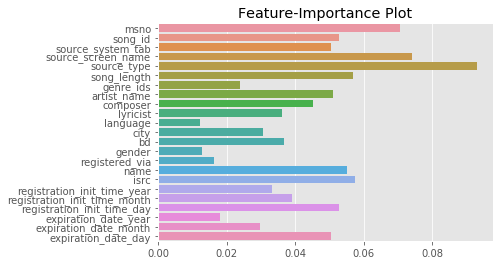

In [15]:
X = train[train.columns[train.columns != 'target']]
y = train.target

model = ensemble.RandomForestClassifier(n_estimators=100, max_depth=25)
model.fit(X, y)

features = train.columns[train.columns != 'target']
importance_values = model.feature_importances_

sns.barplot(x = importance_values, y =features )
plt.title('Feature-Importance Plot')
plt.show()

In [16]:
imporant_feat = pd.concat([(features.to_series().reset_index(drop=True)), pd.DataFrame(importance_values)], axis=1)
imporant_feat.columns = ['features', 'importance_values']
imporant_feat[importance_values>0.05]

,features,importance_values
0,msno,0.070745
1,song_id,0.052876
2,source_system_tab,0.050610
3,source_screen_name,0.074082
4,source_type,0.093018
5,song_length,0.057001
7,artist_name,0.051044
15,name,0.055021
16,isrc,0.057585
19,registration_init_time_day,0.052867


Text(0.5, 1, 'Relationship Between Important Features')

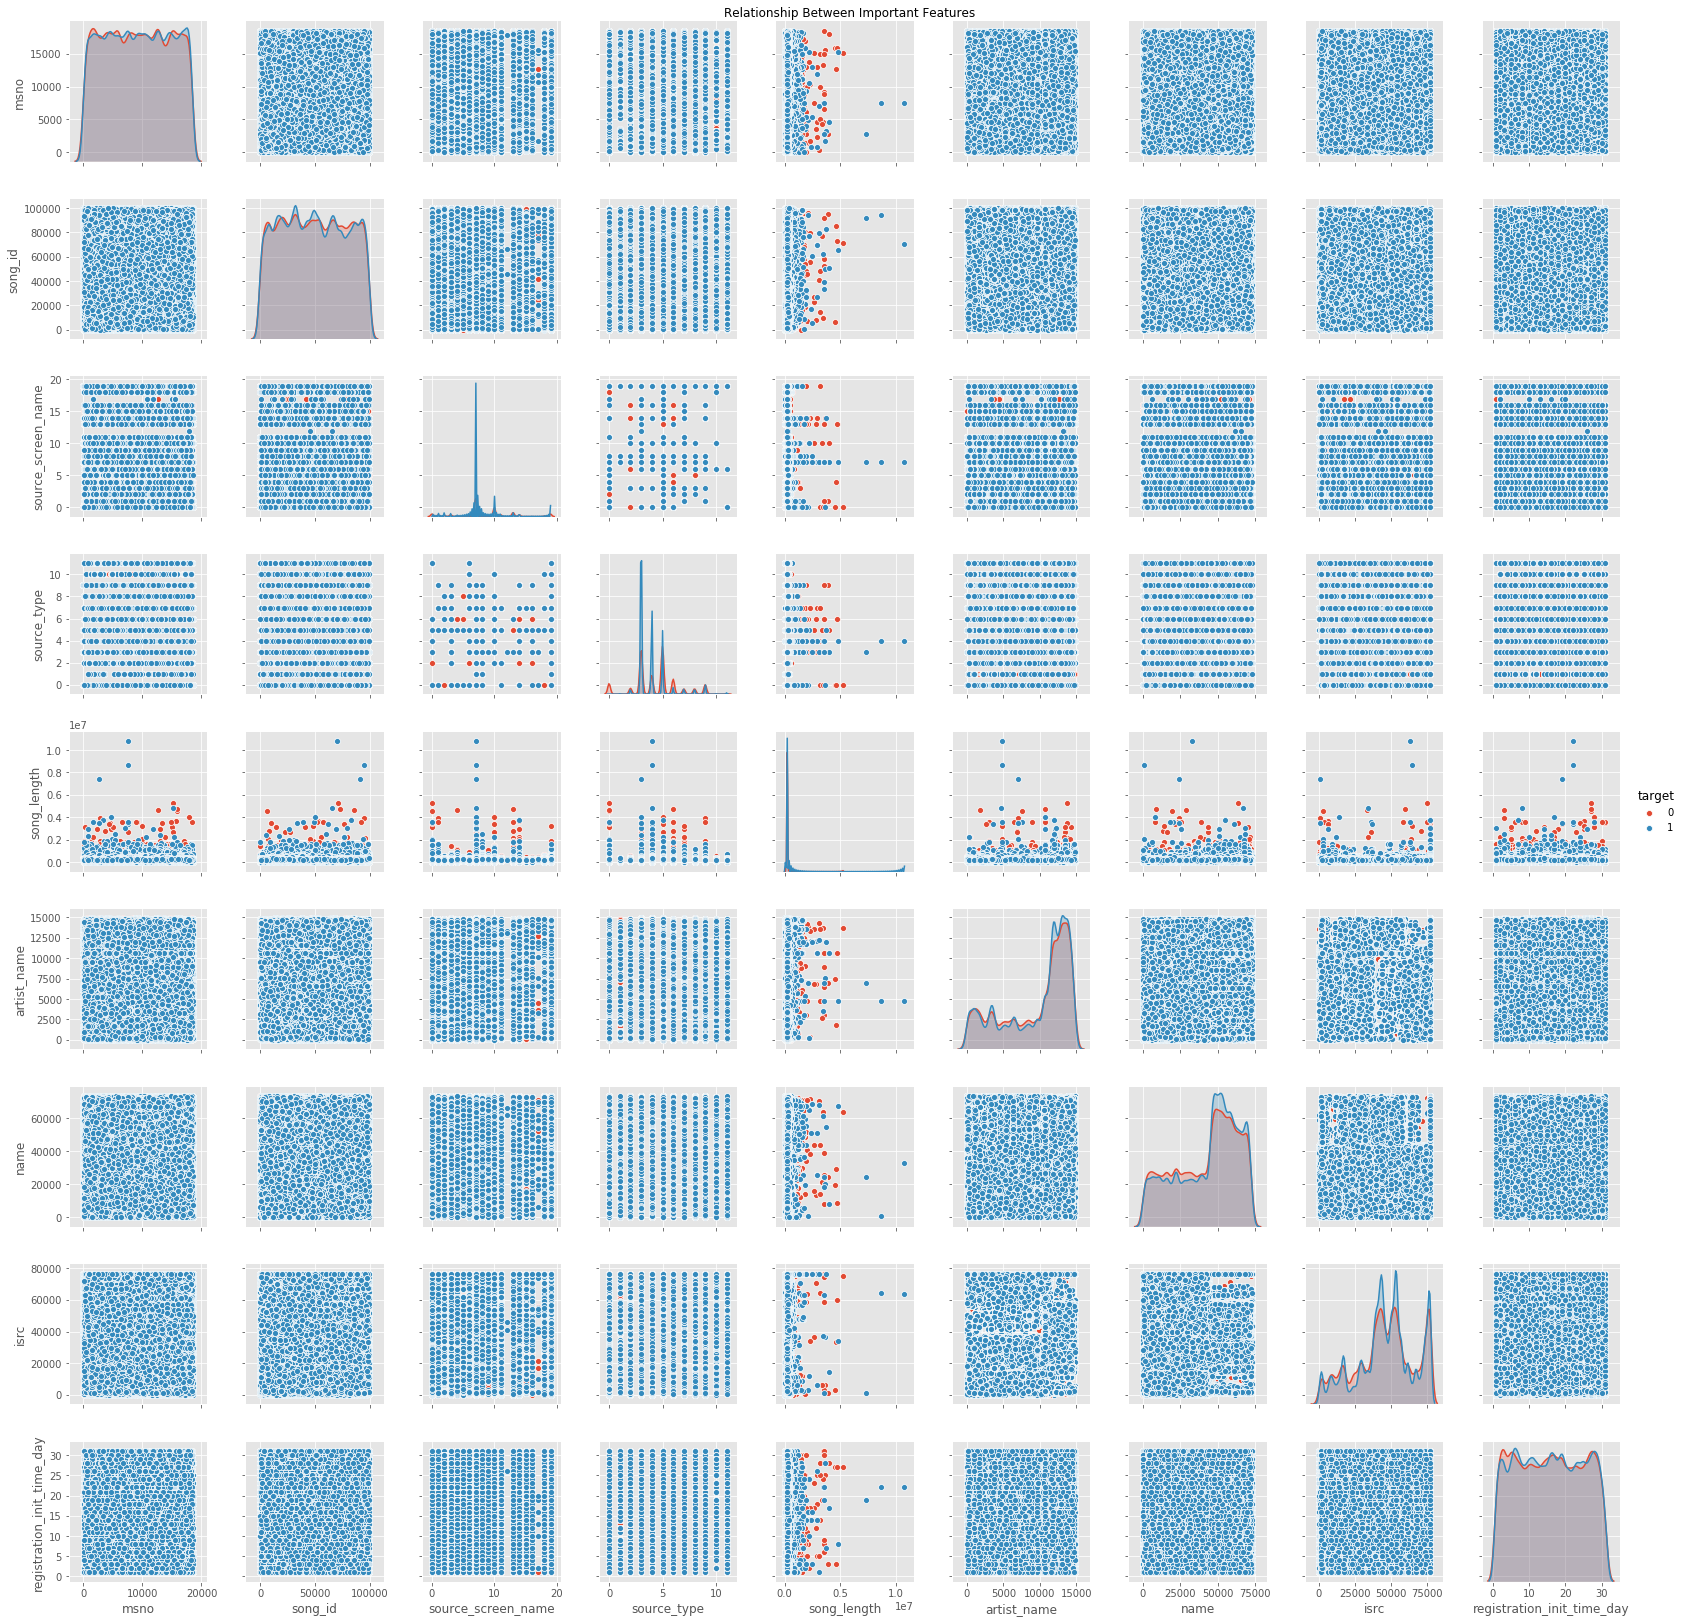

In [18]:
# To have a look at relationship between the important Features >0.05
imporant_features = ['msno', 'song_id', 'source_screen_name','source_type', 'song_length','artist_name','name', 'isrc', 'registration_init_time_day']
pair_plot_imp = sns.pairplot(train, vars=imporant_features, hue='target')
pair_plot_imp.fig.suptitle("Relationship Between Important Features", y=1) 

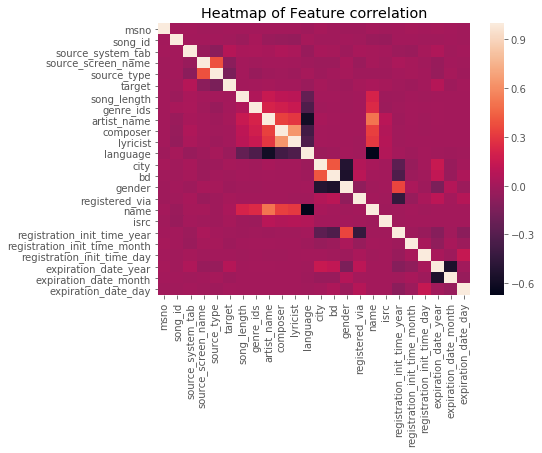

In [17]:
# Heatmap of the Feature correlation
plt.figure(figsize=[7,5])
sns.heatmap(train.corr())
plt.title('Heatmap of Feature correlation')
plt.show()

In [18]:
train.columns
#train.count(axis='columns')

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'city', 'bd', 'gender',
       'registered_via', 'name', 'isrc', 'registration_init_time_year',
       'registration_init_time_month', 'registration_init_time_day',
       'expiration_date_year', 'expiration_date_month', 'expiration_date_day'],
      dtype='object')

In [19]:
target = train.pop('target')

In [20]:
train_data, test_data, train_labels, test_labels = train_test_split(train, target, test_size = 0.3)

In [21]:
import lightgbm as lgb
d_train = lgb.Dataset(train_data, label= train_labels)
params = {}
params['learning_rate']= 0.003
params['boosting_type']='gbdt'
params['objective']='binary'
params['metric']='binary_logloss'
params['sub_feature']=0.5
params['num_leaves']= 10
params['min_data']=50
params['max_depth']=10
clf= lgb.train(params, d_train, 100)
y_pred = clf.predict(test_data)
y_pred = np.where(y_pred > 0.49, 1, 0)

len(y_pred)


from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, test_labels)
accuracy

#from sklearn import metrics
#fpr, tpr, thresholds = metrics.roc_curve(test_labels, y_pred)
#metrics.auc(fpr, tpr)

0.66304

In [22]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import warnings

warnings.simplefilter('ignore')

RANDOM_SEED = 42

clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)

lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2],
                            meta_classifier=lr,
                            random_state=RANDOM_SEED)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, sclf], 
                      ['GradientBoostingClassifier', 
                       'RandomForestClassifier', 
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, train_data, train_labels,cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.72 (+/- 0.00) [GradientBoostingClassifier]
Accuracy: 0.74 (+/- 0.00) [RandomForestClassifier]
Accuracy: 0.73 (+/- 0.00) [StackingClassifier]


In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

classifiers = [
    KNeighborsClassifier(3),
    #SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    print("="*30)
    name = clf.__class__.__name__
    print(name)
    print('****Results****')
    
    clf.fit(train_data, train_labels)
    
    train_predictions = clf.predict(test_data)
    acc = accuracy_score(test_labels, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, train_predictions)
    print(metrics.auc(fpr, tpr))
    
    train_predictions = clf.predict_proba(test_data)
    ll = log_loss(test_labels, train_predictions)
    print("Log Loss: {}".format(ll))
    

    #log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    #log = log.append(log_entry)
    
print("="*30)

In [ ]:
model = xgb.XGBClassifier(max_depth=20,
                          learning_rate=0.1,
                          min_child_weight=3,
                          n_estimators=300,
                         scale_pos_weight=1,
                         seed=1)
model.fit(train_data, train_labels, eval_metric='auc', #verbose=True,
         eval_set=[(test_data, test_labels)], early_stopping_rounds=100)

In [ ]:
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=300)
model.fit(train_data, train_labels)

In [ ]:
predict_labels = model.predict(test_data)

In [ ]:
print(metrics.classification_report(test_labels, predict_labels))

In [ ]:
print(metrics.accuracy_score(test_labels, predict_labels))

In [ ]:
print(metrics.roc_auc_score(test_labels, predict_labels))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
model = Sequential()
model.add(Dense(64, input_dim=23, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.summary()
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=3)
print(train_data.size)
train_data.shape

In [ ]:
model.fit(train_data, train_labels, epochs=25, batch_size=1000, callbacks=[early_stopping_monitor])

In [ ]:
accuracy = model.evaluate(test_data, test_labels)

In [ ]:
#print('Accuracy: %.2f' % (accuracy*100))
print(model.metrics_names)
accuracy